In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss410.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss537.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss295.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss771.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss234.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss620.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss70.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss281.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss393.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss296.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss756.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss260.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss57.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss224.xml
/kaggle/inpu

In [32]:
import pandas as pd
import numpy as np
import cv2
import os
import glob
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
import glob
from xml.etree import ElementTree


In [33]:
annotations_directory = '../input/face-mask-detection/annotations'
images_directory = '../input/face-mask-detection/images'

In [34]:

information = {'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'label': [], 'file': [], 'width': [], 'height': []}

for annotation in glob.glob(annotations_directory + '/*.xml'):
    tree = ElementTree.parse(annotation)
    
    for element in tree.iter():
        if 'size' in element.tag:
            for attribute in list(element):
                if 'width' in attribute.tag: 
                    width = int(round(float(attribute.text)))
                if 'height' in attribute.tag:
                    height = int(round(float(attribute.text)))    

        if 'object' in element.tag:
            for attribute in list(element):
                
                if 'name' in attribute.tag:
                    name = attribute.text                 
                    information['label'] += [name]
                    information['width'] += [width]
                    information['height'] += [height] 
                    information['file'] += [annotation.split('/')[-1][0:-4]] 
                            
                if 'bndbox' in attribute.tag:
                    for dimension in list(attribute):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                            information['xmin'] += [xmin]
                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                            information['ymin'] += [ymin]                                
                        if 'xmax' in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                            information['xmax'] += [xmax]                                
                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                            information['ymax'] += [ymax]

In [35]:
annotations_info_df = pd.DataFrame(information)
annotations_info_df.head(10)

,xmin,ymin,xmax,ymax,label,file,width,height
0,28,55,46,71,with_mask,maksssksksss737,400,226
1,98,62,111,78,with_mask,maksssksksss737,400,226
2,159,50,193,90,mask_weared_incorrect,maksssksksss737,400,226
3,293,59,313,80,with_mask,maksssksksss737,400,226
4,352,51,372,72,with_mask,maksssksksss737,400,226
5,228,53,241,73,with_mask,maksssksksss737,400,226
6,34,153,62,176,with_mask,maksssksksss410,400,267
7,88,138,111,163,with_mask,maksssksksss410,400,267
8,139,207,168,234,with_mask,maksssksksss410,400,267
9,116,135,135,154,with_mask,maksssksksss410,400,267


In [36]:
# Add Annotation and Image File Names
annotations_info_df['annotation_file'] = annotations_info_df['file'] + '.xml'
annotations_info_df['image_file'] = annotations_info_df['file'] + '.png'

# Tidy Grammatical Issue
annotations_info_df.loc[annotations_info_df['label'] == 'mask_weared_incorrect', 'label'] = 'mask_incorrectly_worn'

In [37]:
annotations_info_df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file
0,28,55,46,71,with_mask,maksssksksss737,400,226,maksssksksss737.xml,maksssksksss737.png
1,98,62,111,78,with_mask,maksssksksss737,400,226,maksssksksss737.xml,maksssksksss737.png
2,159,50,193,90,mask_incorrectly_worn,maksssksksss737,400,226,maksssksksss737.xml,maksssksksss737.png
3,293,59,313,80,with_mask,maksssksksss737,400,226,maksssksksss737.xml,maksssksksss737.png
4,352,51,372,72,with_mask,maksssksksss737,400,226,maksssksksss737.xml,maksssksksss737.png
...,...,...,...,...,...,...,...,...,...,...
4067,229,53,241,72,with_mask,maksssksksss13,400,226,maksssksksss13.xml,maksssksksss13.png
4068,51,144,128,239,with_mask,maksssksksss138,400,267,maksssksksss138.xml,maksssksksss138.png
4069,147,169,217,233,with_mask,maksssksksss138,400,267,maksssksksss138.xml,maksssksksss138.png
4070,224,92,309,186,with_mask,maksssksksss138,400,267,maksssksksss138.xml,maksssksksss138.png


In [38]:
def render_image(image_path):
    image = cv2.imread(image_path)
    img=image_path.split('/')[-1]
    #print(image.shape)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bound_box=[]
    for i in annotations_info_df[annotations_info_df['image_file']==img].index:
        (x,y,width,height)=(annotations_info_df.loc[i].xmin,annotations_info_df.loc[i].ymin,
                        annotations_info_df.loc[i].xmax,annotations_info_df.loc[i].ymax)
        bound_box.append((x,y,width,height))  
        if annotations_info_df.loc[i].label=='with_mask':
            cv2.rectangle(image, (x,y), (x+width, y+height), (0, 200, 0), 2)
            cv2.putText(image, org = (x-8 , y-8), text = "Mask", 
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (0, 200, 0))
        elif annotations_info_df.loc[i].label=='mask_incorrectly_worn':
            cv2.rectangle(image, (x,y), (x+width, y+height), (255, 255, 0), 2)
            cv2.putText(image, org = (x - 8, y - 3), text = 'Incorrect', 
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (255, 255, 0))
        else:
            cv2.rectangle(image, (x,y), (x+width, y+height), (200, 0, 0), 2)
            cv2.putText(image, org = (x - 8, y - 3), text = 'No mask', 
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX, fontScale = 0.5, color = (200, 0, 0))
        
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.show()
    
    return bound_box,image

In [39]:
images_with_2=[]
for _ in annotations_info_df['image_file'].value_counts().index:
    if annotations_info_df[annotations_info_df['image_file']==_].shape[0]==2:
        images_with_2.append(_)

In [40]:
len(images_with_2)

100

In [41]:
annotations_info_df.loc[0]

xmin                                28
ymin                                55
xmax                                46
ymax                                71
label                        with_mask
file                   maksssksksss737
width                              400
height                             226
annotation_file    maksssksksss737.xml
image_file         maksssksksss737.png
Name: 0, dtype: object

In [42]:
annotations_info_df

,xmin,ymin,xmax,ymax,label,file,width,height,annotation_file,image_file
0,28,55,46,71,with_mask,maksssksksss737,400,226,maksssksksss737.xml,maksssksksss737.png
1,98,62,111,78,with_mask,maksssksksss737,400,226,maksssksksss737.xml,maksssksksss737.png
2,159,50,193,90,mask_incorrectly_worn,maksssksksss737,400,226,maksssksksss737.xml,maksssksksss737.png
3,293,59,313,80,with_mask,maksssksksss737,400,226,maksssksksss737.xml,maksssksksss737.png
4,352,51,372,72,with_mask,maksssksksss737,400,226,maksssksksss737.xml,maksssksksss737.png
...,...,...,...,...,...,...,...,...,...,...
4067,229,53,241,72,with_mask,maksssksksss13,400,226,maksssksksss13.xml,maksssksksss13.png
4068,51,144,128,239,with_mask,maksssksksss138,400,267,maksssksksss138.xml,maksssksksss138.png
4069,147,169,217,233,with_mask,maksssksksss138,400,267,maksssksksss138.xml,maksssksksss138.png
4070,224,92,309,186,with_mask,maksssksksss138,400,267,maksssksksss138.xml,maksssksksss138.png


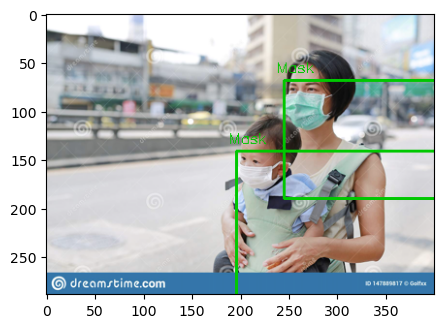

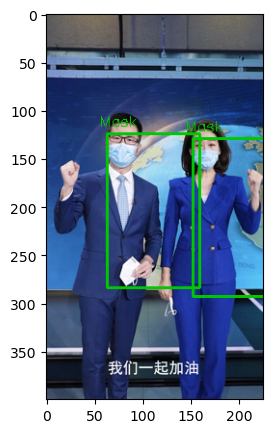

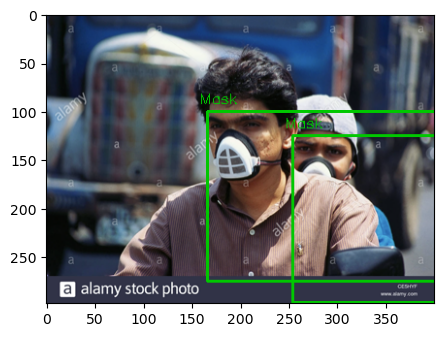

In [43]:
for i in images_with_2[:3]:
    render_image(os.path.join(images_directory,i))



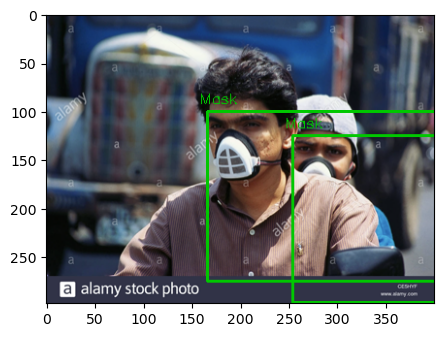

In [44]:

bound_box,image=render_image(os.path.join(images_directory,i))

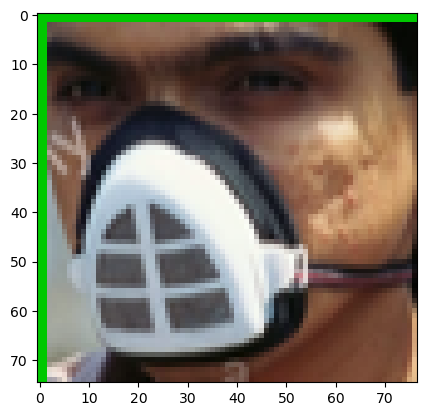

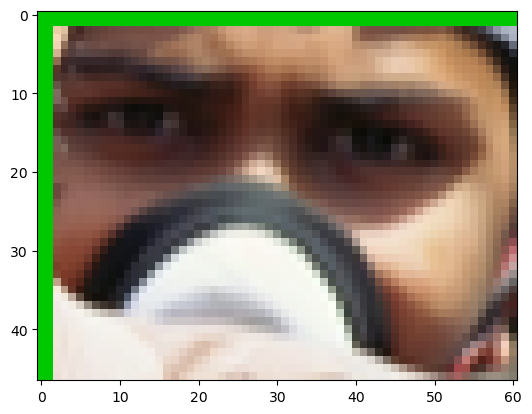

In [45]:
for i in bound_box:
    cropped = image[i[1]:i[3],i[0]:i[2]]
    plt.imshow(cropped)
    plt.show()

In [46]:
directory = 'cropped_images'
parent_directory = '/kaggle/working'
path = os.path.join(parent_directory, directory)
os.mkdir(path)

FileExistsError: [Errno 17] File exists: '/kaggle/working/cropped_images'

In [ ]:
annotations_info_df['cropped_image_file'] = annotations_info_df['file']
annotations_info_df

In [ ]:
for i in range(len(annotations_info_df)):
    # Get The File Path and Read The Image
    image_filepath = '../input/face-mask-detection/images/' + annotations_info_df['image_file'].iloc[i]
    image = cv2.imread(image_filepath)
    
    # Set The Cropped Image File Name
    annotations_info_df['cropped_image_file'].iloc[i] = annotations_info_df['cropped_image_file'].iloc[i] + '-' + str(i) + '.png'
    cropped_image_filename = annotations_info_df['cropped_image_file'].iloc[i]
    
    # Get The xmin, ymin, xmax, ymax Value (Bounding Box) to Crop Image
    xmin = annotations_info_df['xmin'].iloc[i]
    ymin = annotations_info_df['ymin'].iloc[i]
    xmax = annotations_info_df['xmax'].iloc[i]
    ymax = annotations_info_df['ymax'].iloc[i]

    # Crop The Image Based on The Values Above
    cropped_image = image[ymin:ymax, xmin:xmax]
    
    cropped_image_directory = os.path.join('./cropped_images', cropped_image_filename) 
    cv2.imwrite(cropped_image_directory, cropped_image)

In [ ]:
annotations_info_df

In [ ]:
classes=annotations_info_df['label'].unique()

In [ ]:
labels=annotations_info_df['label']
annotations_info_df.drop(['label'],axis=1,inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(annotations_info_df,labels,test_size=0.25,stratify=labels,random_state=42)

In [ ]:
print(X_train.shape,X_test.shape)

In [ ]:
Y_train.value_counts()

In [ ]:
image_width = []
image_height = []
for i in range(len(X_train)):
    cropped_image_path = './cropped_images/' + X_train['cropped_image_file'].iloc[i]
    cropped_image = cv2.imread(cropped_image_path)
    image_width.append(cropped_image.shape[0])
    image_height.append(cropped_image.shape[1])

In [ ]:
print('IMAGE WIDTH')
print(f'Min: {min(image_width)}')
print(f'Max: {max(image_width)}')
print(f'Mean: {np.mean(image_width)}')
print(f'Median: {np.median(image_width)}')
print('IMAGE HEIGHT')
print(f'Min: {min(image_height)}')
print(f'Max: {max(image_height)}')
print(f'Mean: {np.mean(image_height)}')
print(f'Median: {np.median(image_height)}')

In [ ]:
image_target_size = (int(60), int(60))
image_target_size

In [ ]:
X_train['label']=Y_train
X_test['label']=Y_test

In [ ]:
X_train

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale = 1. / 255.)

train_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_train,
    directory = './cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    subset = 'training',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

In [ ]:
class_ind=train_generator.class_indices

In [ ]:
test_image_generator = ImageDataGenerator(rescale = 1. / 255.)

test_generator = train_image_generator.flow_from_dataframe(
    dataframe = X_test,
    directory = './cropped_images',
    x_col = 'cropped_image_file',
    y_col = 'label',
    batch_size = 32,
    seed = 42,
    shuffle = True,
    class_mode = 'categorical',
    target_size = image_target_size
)

In [ ]:
test_generator.class_indices

In [ ]:

def my_model():
    inputs = keras.Input(shape=(60,60, 3))
    x = layers.Conv2D(32, 3)(inputs)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
#     x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3)(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
#     x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3)(x)
    x = layers.BatchNormalization()(x)
    x = keras.activations.relu(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x=layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(3,activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model=my_model()
print(model.summary())

In [ ]:
model.compile(loss = 'categorical_crossentropy',
                optimizer = keras.optimizers.Adam(lr=0.001),
                metrics = ['accuracy'])

history_1 = model.fit(train_generator, epochs = 10, steps_per_epoch = len(train_generator),
                     validation_data = test_generator, validation_steps = len(test_generator))


In [ ]:
model.save('face_mask_detection.h5')

In [ ]:
cropped_image_directory = os.path.join('./cropped_images', cropped_image_filename) 


In [ ]:
image=cv2.imread(cropped_image_directory)
image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
plt.imshow(image)

In [ ]:
bigger = cv2.resize(image, (60,60))
plt.imshow(bigger)

In [ ]:
bigger=bigger/255

In [ ]:
bigger=bigger.reshape(1,60,60,3)

In [ ]:
class_ind

In [ ]:
pred_val=np.argmax(model.predict(bigger))

In [ ]:
y_pred=[]
for i,j in class_ind.items():
    if pred_val==j:
        y_pred.append(i)

In [ ]:
y_pred